In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import matplotlib.colors as clrs

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import bt

In [25]:
# Change...
pair = 'BTCUSDT'
# valid strategy intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
interval = '1D'
# date to start/end analysis
dt_start_analysis = '2011-4-1'
# Use '' for analysis until now
dt_end_analysis = ''

# Gathering data

In [26]:
from binance_utils import init
from glassnode_utils import get_price_ohlc

data = get_price_ohlc()

# Target variable

In [36]:
from machine_learning_utils import get_labels_future_returns

data['signal'] = get_labels_future_returns(data[['ClosePrice']].copy(), 0.05)
data.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,signal
t,,,,,
2022-08-15,24318.315483,25117.225375,23844.732706,24147.307825,0.0
2022-08-16,24126.136483,24228.415612,23742.248066,23892.484440,0.0
2022-08-17,23881.315512,24403.716056,23250.433555,23318.944335,0.0
2022-08-18,23341.038978,23562.039172,23184.563433,23217.331295,0.0
2022-08-19,23213.313242,23213.313242,21349.033164,21349.033164,0.0


In [40]:
#print(data.describe())
#print(data)
#print(data[data['signal'] == 1.0]).tail(30)
#print(data[data['signal'] == -1.0])
print(data['2022-07-01':'2022-07-31'])

               OpenPrice     HighPrice      LowPrice    ClosePrice  signal
t                                                                         
2022-07-01  19842.008804  20585.973447  19101.110519  19329.323524     0.0
2022-07-02  19286.772155  19364.981217  19027.081355  19241.928103     0.0
2022-07-03  19242.056139  19542.409472  18966.950634  19298.575155     1.0
2022-07-04  19297.076083  20251.369454  19063.066195  20251.369454    -1.0
2022-07-05  20231.261512  20605.468505  19341.233154  20176.558872     0.0
2022-07-06  20190.114670  20592.166350  19823.511203  20561.936326     1.0
2022-07-07  20547.814241  21732.555669  20296.103122  21645.871687     0.0
2022-07-08  21637.155052  22230.894626  21265.184808  21822.087776    -1.0
2022-07-09  21716.828585  21874.128637  21462.092477  21588.652872     0.0
2022-07-10  21592.206074  21592.206074  20749.442927  20856.264413     0.0
2022-07-11  20856.352968  20856.352968  19945.395182  19991.536784     0.0
2022-07-12  19970.475023 

# Features

In [41]:
from technical_indicator_utils import get_sma, get_ema, get_macd, get_rsi, get_adx, get_bbands

# Calculate returns
data['Returns'] = data['ClosePrice'].pct_change() # pct_change() = percent change from previous price
data['Returns30'] = data['ClosePrice'].pct_change(30) # change from 30 previous price

# Volatility
data['Volatility'] = data.rolling(30, min_periods = 30)['Returns'].std()

data['VolatilityCandle'] = (data['HighPrice'] - data['LowPrice']).diff()

# SMA
data['SMA5'] = get_sma(data['ClosePrice'], 5)
data['SMA10'] = get_sma(data['ClosePrice'], 10)
data['SMA20'] = get_sma(data['ClosePrice'], 20)
data['SMA30'] = get_sma(data['ClosePrice'], 30)
data['SMA50'] = get_sma(data['ClosePrice'], 50).diff()
data['SMA100'] = get_sma(data['ClosePrice'], 100)
data['SMA200'] = get_sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = get_ema(data['ClosePrice'], 5)
data['EMA10'] = get_ema(data['ClosePrice'], 10)
data['EMA20'] = get_ema(data['ClosePrice'], 20)
data['EMA30'] = get_ema(data['ClosePrice'], 30)
data['EMA50'] = get_ema(data['ClosePrice'], 50)
data['EMA100'] = get_ema(data['ClosePrice'], 100).diff()
data['EMA200'] = get_ema(data['ClosePrice'], 200).diff()

# MACD
data['MACD'], data['MACDSignal'], data['MACDHist'] = get_macd(data['ClosePrice'])

# RSI
data['RSI'] = get_rsi(data['ClosePrice'])

# ADX
data['DI+'], data['DI-'], data['ADX'] = get_adx(data['HighPrice'], data['LowPrice'], data['ClosePrice'])

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = get_bbands(data['ClosePrice'])

In [42]:
# limit data model
if dt_end_analysis == '':
    data = data[dt_start_analysis:]
else:
    data = data[dt_start_analysis:dt_end_analysis]

# Drop the missing values
data.dropna(inplace=True)

# Create X and y

In [43]:
# Target
y = data[['signal']].copy()

# Features
X = data[['Returns', 'Returns30', 'Volatility', 'VolatilityCandle'
        , 'SMA50', 'EMA100', 'EMA200'
       ,'MACD', 'MACDHist'
       ,'RSI', 'ADX'
       #,'UpperBBand', 'MidiBBand', 'LowerBBand'
       ]].copy()

## Sationary check

In [44]:
from machine_learning_utils import is_stationary

# Check for stationarity
for col in X.columns:
    if not is_stationary(data[col]):
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

Returns is stationary.
Returns30 is stationary.
Volatility is stationary.
VolatilityCandle is stationary.
SMA50 is stationary.
EMA100 is stationary.
EMA200 is stationary.
MACD is stationary.
MACDHist is stationary.
RSI is stationary.
ADX is stationary.


## Correlation check

In [45]:
from machine_learning_utils import get_pair_above_threshold

print(get_pair_above_threshold(X, 0.7))

MultiIndex([('EMA100', 'EMA200'),
            ( 'SMA50', 'EMA100'),
            ('EMA100',   'MACD'),
            ( 'SMA50',   'MACD'),
            ( 'SMA50', 'EMA200'),
            ('EMA200',   'MACD')],
           )


In [11]:
# Drop the highly correlated column
X = X.drop(columns=['MACDSignal'], axis=1)

KeyError: "['DI+'] not found in axis"

In [46]:
X.head()

,Returns,Returns30,Volatility,VolatilityCandle,SMA50,EMA100,EMA200,MACD,MACDHist,RSI,ADX
t,,,,,,,,,,,
2011-04-01,-0.013382,-0.176391,0.033836,-0.010110,-0.004021,0.001583,0.002614,-0.020729,-0.004806,40.86,18.634995
2011-04-02,0.010179,-0.167290,0.033953,0.001930,-0.005760,0.001708,0.002667,-0.021400,-0.004382,42.32,18.537505
2011-04-03,-0.003824,-0.135597,0.033310,-0.009700,-0.006018,0.001615,0.002610,-0.021921,-0.003922,41.90,18.446979
2011-04-04,-0.127086,-0.252994,0.040006,0.184988,-0.007400,-0.000377,0.001599,-0.029976,-0.009582,30.89,21.130086
2011-04-05,0.044118,-0.199215,0.041008,-0.032288,-0.007307,0.000224,0.001882,-0.033553,-0.010527,36.35,23.661137


# Train-test split

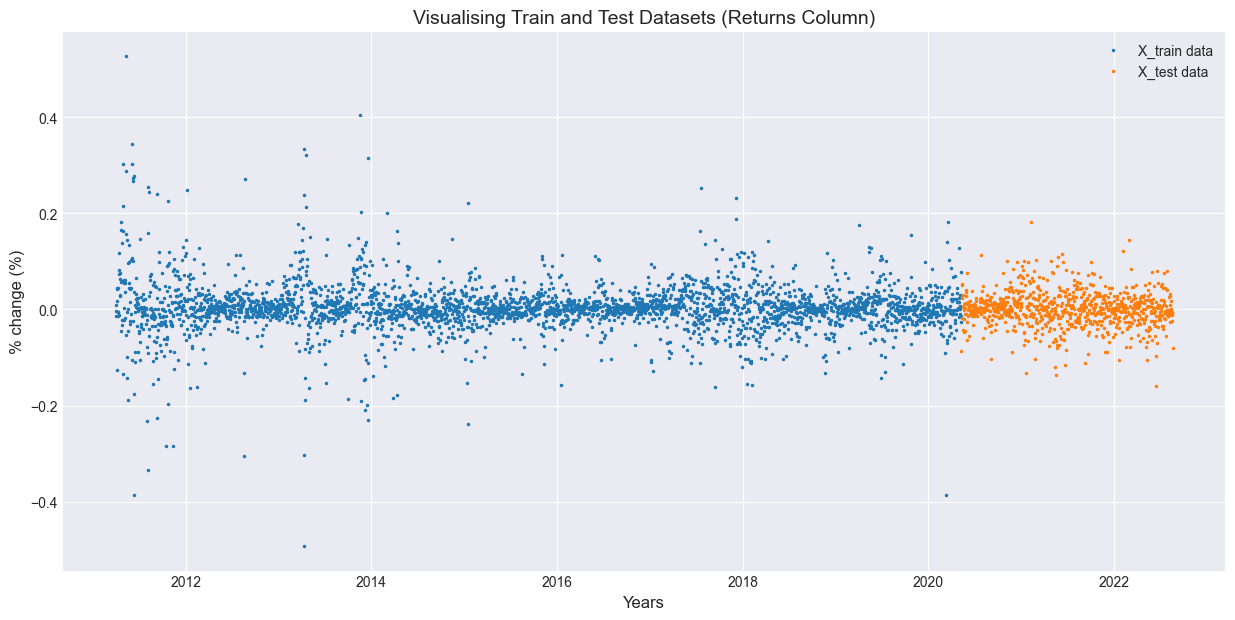

In [47]:
# Obtain the features and target for the 'train_data' and 'test_data' without shuffling
# shuffle is not correct to use in time-series analysis because the order of data is crucial
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, shuffle=False)

# Plot the data
plt.figure(figsize=(15, 7))

plt.plot(X_train['Returns'], linestyle='None',
         marker='.', markersize=3.0, label='X_train data')
plt.plot(X_test['Returns'], linestyle='None',
         marker='.', markersize=3.0, label='X_test data')

# Set the title and axis label
plt.title("Visualising Train and Test Datasets (Returns Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)

# Display the plot
plt.legend()
plt.show()

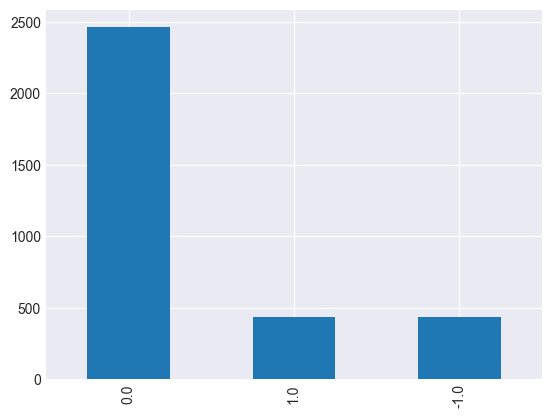

In [48]:
y_train.signal.value_counts().plot(kind='bar')
#plt.xticks(rotation=45)
plt.show()

# Machine Learning classification and forecasting

In [49]:
# Create the machine learning model
rf_model = RandomForestClassifier(
    n_estimators=3, max_features=3, max_depth=2, random_state=4)

# Fit the model on the training data
rf_model.fit(X_train, y_train['signal'])

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=3,
                       random_state=4)

In [50]:
#lg_model = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
#lg_model.fit(X_train, y_train['signal'])

LogisticRegression(class_weight='balanced', max_iter=10000)

## Forecast data

In [51]:
# Get a sample day of data from X_test
unseen_data_single_day = X_test.head(1)

# Preview the data
unseen_data_single_day

,Returns,Returns30,Volatility,VolatilityCandle,SMA50,EMA100,EMA200,MACD,MACDHist,RSI,ADX
t,,,,,,,,,,,
2020-05-10,-0.086419,0.276639,0.038657,835.508707,51.766649,17.411718,7.329405,598.800032,41.973555,55.7,39.161768


In [52]:
# choose model to evaluate
model = rf_model

# Get the prediction of a single day
single_day_prediction = model.predict(unseen_data_single_day)

# Preview the prediction
single_day_prediction

array([0.])

In [53]:
# Use the model and predict the values for the test data
y_pred = model.predict(X_test)

# Display the first five predictions
print("The first five predicted values", y_pred[:5])

The first five predicted values [0. 0. 0. 0. 0.]


# Metrics

## Accuracy

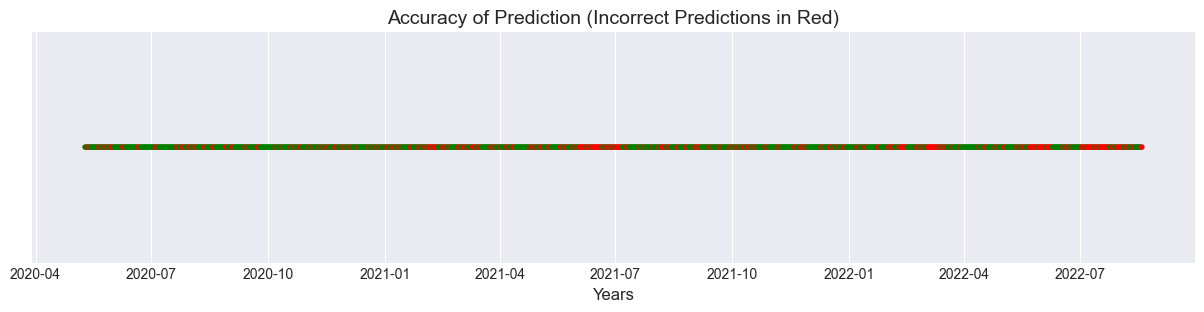

The accuracy is 65.62%.


In [54]:
# Define the accuracy data
y_test_values = y_test['signal'].values
accuracy_data = (y_pred == y_test_values)

# Accuracy percentage
accuracy_percentage = round(100 * accuracy_data.sum()/len(accuracy_data), 2)

# Plot the accuracy data
plt.figure(figsize=(15, 3))

# Colour mapping for the correct and incorrect predictions
cmap = clrs.ListedColormap(['green', 'red'])

plt.yticks([])
plt.scatter(x=y_test.index, y=[1]*len(y_test),
            c=(accuracy_data != True).astype(float), marker='.', cmap=cmap)

# Set the title and axis label
plt.title("Accuracy of Prediction (Incorrect Predictions in Red)", fontsize=14)
plt.xlabel('Years', fontsize=12)

# Display the results
plt.show()
print(f"The accuracy is {accuracy_percentage}%.")

## Confusion Matrix

In [55]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

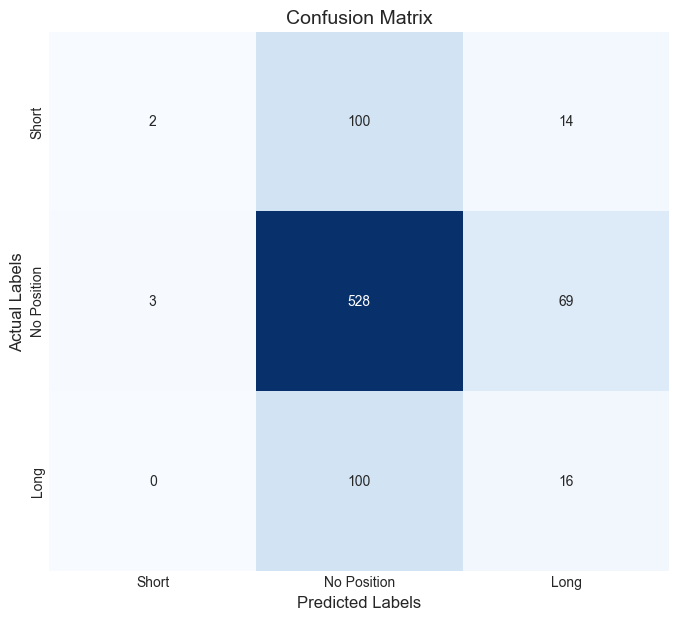

In [57]:
# Define the confusion matrix
confusion_matrix_data = confusion_matrix(y_test_values, y_pred)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(confusion_matrix_data, fmt="d",
            cmap='Blues', cbar=False, annot=True, ax=ax)

# Set the axes labels and the title
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['Short', 'No Position', 'Long'])
ax.yaxis.set_ticklabels(['Short', 'No Position', 'Long'])

# Display the plot
plt.show()

## Classification report

In [58]:
# Classification report
classification_report_data = classification_report(y_test_values, y_pred)

# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

        -1.0       0.40      0.02      0.03       116
         0.0       0.73      0.88      0.80       600
         1.0       0.16      0.14      0.15       116

    accuracy                           0.66       832
   macro avg       0.43      0.35      0.33       832
weighted avg       0.60      0.66      0.60       832



# Strategy backtesting

In [59]:
strategy_data = pd.DataFrame(index=y_test.index, columns = ['ClosePrice', 'signal'])
strategy_data['signal'] = y_pred
strategy_data['ClosePrice'] = data.loc[strategy_data.index]['ClosePrice']
strategy_data.head()

,ClosePrice,signal
t,,
2020-05-10,8761.299747,0.0
2020-05-11,8599.781947,0.0
2020-05-12,8800.729722,0.0
2020-05-13,9274.856203,0.0
2020-05-14,9742.732853,0.0


## Strategy returns

In [60]:
# Calculate the percentage change
strategy_data['pct_change'] = strategy_data['ClosePrice'].pct_change()

# Calculate the strategy returns
strategy_data['strategy_returns'] = strategy_data['signal'].shift(1) * \
    strategy_data['pct_change']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,ClosePrice,signal,pct_change,strategy_returns
t,,,,
2020-05-11,8599.781947,0.0,-0.018435,-0.0
2020-05-12,8800.729722,0.0,0.023367,0.0
2020-05-13,9274.856203,0.0,0.053874,0.0
2020-05-14,9742.732853,0.0,0.050446,0.0
2020-05-15,9324.749559,0.0,-0.042902,-0.0


## Equity Curve

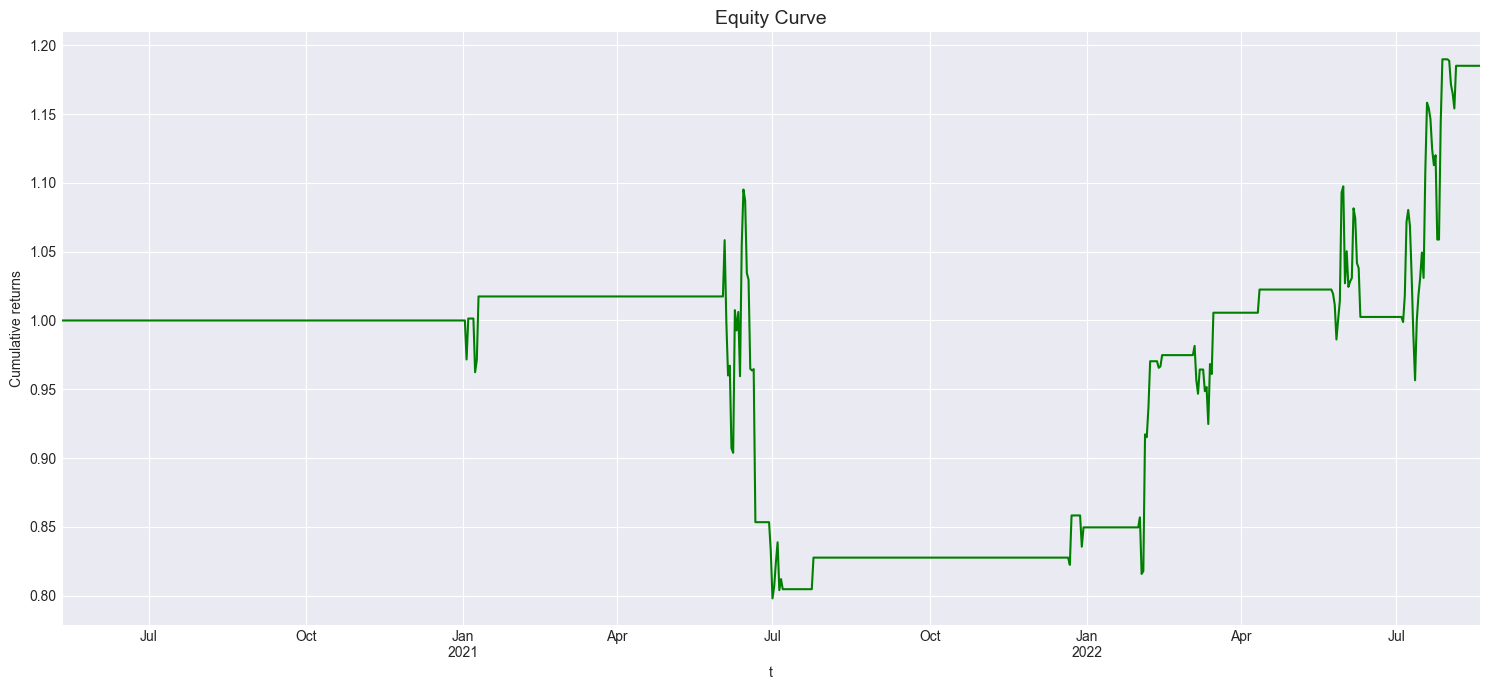

The cumulative return is 18.51%.


In [61]:
# Calculate the cumulative returns
strategy_data['cumulative_returns'] = (
    1+strategy_data['strategy_returns']).cumprod()

# ---------------------Equity Curve---------------------
# Plot cumulative strategy returns
strategy_data['cumulative_returns'].plot(figsize=(15, 7), color='green')
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative returns')
plt.tight_layout()
plt.show()

cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1)*100
print("The cumulative return is {0:.2f}%.".format(cumulative_returns))

In [55]:
# For 1H strategy, year = 8760
# Calculate the annualised returns
annualised_return = ((strategy_data['cumulative_returns'][-1]) **
                    (8760/strategy_data.shape[0]) - 1) * 100
print("The annualised return is {0:.2f}%.".format(annualised_return))

The annualised return is 0.00%.


In [56]:
# Calculate the annualised volatility
annualised_volatility = strategy_data['strategy_returns'].std()*np.sqrt(
    8760) * 100
print("The annualised volatility is {0:.2f}%.".format(annualised_volatility))

The annualised volatility is 0.00%.


In [ ]:
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy_data['cumulative_returns'].dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = ((strategy_data['cumulative_returns'])/running_max - 1) * 100

# Calculate the maximum drawdown
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# ---------------------DD plot---------------------
fig = plt.figure(figsize=(15, 7))

# Plot max drawdown
plt.plot(drawdown, color='red')
# Fill in-between the drawdown
plt.fill_between(drawdown.index, drawdown.values, color='red')
plt.title('Strategy Drawdown', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the Sharpe ratio
sharpe_ratio = round(strategy_data['strategy_returns'].mean() /
                     strategy_data['strategy_returns'].std() * np.sqrt(8760), 2)
print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))

## Strategy backtest using bt package

In [ ]:
from backtest_utils import signal_strategy

# Get the price data
price_data = strategy_data[['ClosePrice']].copy()
bt_strategy = signal_strategy(strategy_data[['ClosePrice']].copy(), strategy_data[['signal']].copy(), 'rf')

bt_result = bt.run(bt_strategy)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [ ]:
bt_result.display()